In [1]:
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

from plotnine import *
from scipy.stats import ttest_ind
import numpy as np

# Helper functions

In [2]:
def plot_score(df_total, score_column):
    min_num_examples = 20
    
    # Calculate the counts for each combination of category and outlier status
    category_counts = df_total.groupby(['Most_severe_VEP_consequence', 'FRASER_Splicing_outlier']).size().reset_index(name='counts')

    # Filter for categories with at least 5 data points for both outliers and non-outliers
    valid_categories = category_counts.pivot(index='Most_severe_VEP_consequence', columns='FRASER_Splicing_outlier', values='counts')
    valid_categories = valid_categories[(valid_categories[True] >= min_num_examples) & (valid_categories[False] >= min_num_examples)]
    valid_categories = valid_categories.index.tolist()

    # Filter the original DataFrame to only include these categories
    df_filtered = df_total[df_total['Most_severe_VEP_consequence'].isin(valid_categories)]

    plt.figure(figsize=(10,20))
    # Now create the boxplot with the filtered DataFrame
    plot = (
        ggplot(df_filtered, aes(x='FRASER_Splicing_outlier', y=score_column, fill='FRASER_Splicing_outlier'))
        + geom_boxplot(position=position_dodge(width=0.7))  # Dodge to put boxplots side by side within each facet
        + labs(
            y=score_column, 
            # title='Comparison of Variant Scores by Consequence and Outlier Status'
        )
        + facet_wrap('~Most_severe_VEP_consequence', scales='free_y', ncol=5)  # Facet by variant category
        + theme(
            axis_text_x=element_blank(),  # Remove x-axis text
            subplots_adjust={'wspace': 0.25},  # Adjust space between facets if needed
            legend_position='right',  # Place legend to the right of the plot
            figure_size=(10,5)
        )
        + guides(fill=guide_legend(title="Outlier Status"))  # Customize the legend title
    )

    # Print the plot
    print(plot)

In [3]:
def perform_t_tests(df, score_column):
    p_values = {}
    categories = df['Most_severe_VEP_consequence'].unique()
    for cat in categories:
        df_cat = df[df['Most_severe_VEP_consequence'] == cat]
        outliers = df_cat[df_cat['FRASER_Splicing_outlier'] == True][score_column]
        non_outliers = df_cat[df_cat['FRASER_Splicing_outlier'] == False][score_column]
        if len(outliers) >= 5 and len(non_outliers) >= 5:
            t_stat, p_val = ttest_ind(outliers, non_outliers, equal_var=False, alternative='greater')
            p_values[cat] = p_val
    return p_values

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score, precision_recall_curve

def plot_roc_curve(recall, fpr):
    plot_curve(fpr, recall)
    plt.xlabel('FPR')
    plt.ylabel('Recall')
    plot_x_eq_y()


def plot_curve(recall, other_score, xlim=(0, 1.01), ylim=(0, 1.01), color=None):
    if color == None:
        plt.step(recall, other_score, where='post')
    else:
        plt.step(recall, other_score, where='post', color=color)
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)


def plot_precision_recall_curve(recall, precision, color=None):
    if color == None:
        plot_curve(recall, precision)
    else:
        plot_curve(recall, precision, color=color)
    plt.xlabel('Recall')
    plt.ylabel('Precision')


def plot_multi_precision_recall_curve(benchmark, ndigits=4, colors=None):
    performance = dict()
    legends = list()

    count = 0
    for k, (target, prediction) in benchmark.items():
        precision, recall, threshold = precision_recall_curve(
            target, prediction)
        if colors == None:
            plot_precision_recall_curve(recall, precision)
        else:
            plot_precision_recall_curve(recall, precision, color=colors[count])
            count += 1
        aps = average_precision_score(target, prediction)
        aps = round(aps, ndigits)
        legends.append(f'{k}, AP={aps}')
        performance[k] = {
            'precision': precision,
            'recall': recall,
            'threshold': threshold,
            'aps': aps
        }
    plt.legend(legends)

    return performance


def get_dataframe_for_ggplot(performance):
    df_performance = pd.DataFrame(performance).transpose().reset_index().rename(columns={'index': 'model'})[['model', 'precision', 'recall']]
    df_performance = df_performance.set_index('model').apply(pd.Series.explode).reset_index()
    df_performance['precision'] = df_performance['precision'].astype(float)
    df_performance['recall'] = df_performance['recall'].astype(float)
    
    df_aps = pd.DataFrame(performance).transpose().reset_index().rename(columns={'index': 'model'})[['model', 'aps']]
    df_performance = df_performance.set_index('model').join(df_aps.set_index('model')).reset_index()
    return df_performance


def get_performance(df, outlier_column, model_dict, colors=None):

    try:
        df[outlier_column] = df[outlier_column].fillna(0).astype(int)
    except:
        if 'True' in df[outlier_column].values:
            df[outlier_column] = df[outlier_column] == 'True'
        df[outlier_column] = df[outlier_column].astype(int)
        
    plot_dict = dict()
    for model in tqdm(model_dict.keys()):
        plot_dict[model] = (
            df[outlier_column], 
            np.abs(df[model_dict[model]]).fillna(0)
        )

    _performance = plot_multi_precision_recall_curve(
        plot_dict,
        ndigits=3,
        colors=colors
    )
    
    return get_dataframe_for_ggplot(_performance), _performance

In [5]:
tissues = [
    'Adipose_Subcutaneous',
    'Adipose_Visceral_Omentum',
    'Adrenal_Gland',
    'Artery_Aorta',
    'Artery_Coronary',
    'Artery_Tibial',
    'Brain_Amygdala',
    'Brain_Anterior_cingulate_cortex_BA24',
    'Brain_Caudate_basal_ganglia',
    'Brain_Cerebellar_Hemisphere',
    'Brain_Cerebellum',
    'Brain_Cortex',
    'Brain_Frontal_Cortex_BA9',
    'Brain_Hippocampus',
    'Brain_Hypothalamus',
    'Brain_Nucleus_accumbens_basal_ganglia',
    'Brain_Putamen_basal_ganglia',
    'Brain_Spinal_cord_cervical_c_1',
    'Brain_Substantia_nigra',
    'Breast_Mammary_Tissue',
    'Cells_Cultured_fibroblasts',
    'Cells_EBV_transformed_lymphocytes',
    'Colon_Sigmoid',
    'Colon_Transverse',
    'Esophagus_Gastroesophageal_Junction',
    'Esophagus_Mucosa',
    'Esophagus_Muscularis',
    'Heart_Atrial_Appendage',
    'Heart_Left_Ventricle',
    'Kidney_Cortex',
    'Liver',
    'Lung',
    'Minor_Salivary_Gland',
    'Muscle_Skeletal',
    'Nerve_Tibial',
    'Ovary',
    'Pancreas',
    'Pituitary',
    'Prostate',
    'Skin_Not_Sun_Exposed_Suprapubic',
    'Skin_Sun_Exposed_Lower_leg',
    'Small_Intestine_Terminal_Ileum',
    'Spleen',
    'Stomach',
    'Testis',
    'Thyroid',
    'Uterus',
    'Vagina',
    'Whole_Blood'
]

# Read in SpliceMaps

In [ ]:
df_sm3 = []
df_sm5 = []

for t in tqdm(tissues):
    splicemap_paths5 = f'{t}_splicemap_psi5.csv.gz'
    splicemap_paths3 = f'{t}_splicemap_psi3.csv.gz'
    _df5 = pd.read_csv(splicemap_paths5, skiprows=1)
    _df3 = pd.read_csv(splicemap_paths3, skiprows=1)
    _df5['tissue'] = t
    _df3['tissue'] = t
    
    _df5 = _df5[_df5['gene_type'] == 'protein_coding']
    _df3 = _df3[_df3['gene_type'] == 'protein_coding']
    
    df_sm5.append(_df5)
    df_sm3.append(_df3)

df_sm5 = pd.concat(df_sm5)
df_sm3 = pd.concat(df_sm3)

In [ ]:
df_sm = pd.concat([df_sm5, df_sm3])

In [ ]:
df_sm_all = pd.concat([df_sm5, df_sm3])

## check for tissue specific splice sites

In [ ]:
df_sm = df_sm[
    (df_sm['median_n'] > 10)
    & (df_sm['ref_psi'] > 0.8)
]

In [ ]:
splice_sites_liver = set(df_sm[
    df_sm['tissue'] == 'Liver'
]['splice_site'])

In [ ]:
splice_sites_other_tissues = set(df_sm[
    df_sm['tissue'] != 'Liver'
]['splice_site'])

In [ ]:
# splice_sites_other_tissues

In [ ]:
len(splice_sites_liver.difference(splice_sites_other_tissues))

In [ ]:
df_sm = df_sm[
    (df_sm['median_n'] > 10)
    # & (df_sm['ref_psi'] > 0.8)
]

In [ ]:
splice_sites_liver = set(df_sm[
    df_sm['tissue'] == 'Liver'
]['splice_site'])

In [ ]:
splice_sites_other_tissues = set(df_sm[
    df_sm['tissue'] != 'Liver'
]['splice_site'])

In [ ]:
# splice_sites_other_tissues

In [ ]:
liver_specific = sorted(splice_sites_liver.difference(splice_sites_other_tissues))

In [ ]:
df_sm[
    df_sm['splice_site'].isin(liver_specific)
]

In [ ]:
cols = [
    'junctions', 'gene_id', 'Chromosome', 'Start', 'End', 'Strand',
       'splice_site', 'events', 'ref_psi', 'k', 'n', 'median_n', 'gene_name',
       # 'gene_type', 'novel_junction', 'weak_site_donor', 'weak_site_acceptor',
       # 'transcript_id', 
    'gene_tpm', 'tissue'
]

In [ ]:
df_sm[
    (df_sm['tissue'] != 'Liver')
    # & (df_sm['gene_id'] == 'ENSG00000049239')
].sort_values(by='Start')[cols]['gene_id'].unique()

In [ ]:
df_sm[
    (df_sm['tissue'] == 'Adipose_Subcutaneous')
    & (df_sm['gene_id'] == 'ENSG00000049239')
].sort_values(by='Start')

In [ ]:
df_sm[
    df_sm['gene_id'] == 'ENSG00000049239'
][['tissue', 'gene_tpm']].drop_duplicates()

# Compare outliers vs non-outliers

In [ ]:
df_outlier = []
df_non_outlier = []
df_non_outlier_random = []
missing = []

for tissue in tqdm(tissues):
    try:
        df_outlier.append(pd.read_parquet(f'benchmark_variant_scores_outliers_{tissue}.parquet'))
        df_non_outlier.append(pd.read_parquet(f'benchmark_variant_scores_non_outliers_{tissue}.parquet'))
    except:
        missing.append(tissue)
        pass

df_outlier = pd.concat(df_outlier)
df_non_outlier = pd.concat(df_non_outlier)

In [ ]:
missing

In [ ]:
len(set(df_non_outlier['Variant']).intersection(set(df_outlier['Variant'])))

In [ ]:
df_non_outlier = df_non_outlier[
    ~df_non_outlier['Variant'].isin(set(df_non_outlier['Variant']).intersection(set(df_outlier['Variant'])))
]

In [ ]:
set(df_non_outlier['Variant']).intersection(set(df_outlier['Variant']))

In [ ]:
set(df_outlier['FRASER_Splicing_outlier']), set(df_non_outlier['FRASER_Splicing_outlier'])

In [ ]:
len(set(df_outlier['tissue'])), len(set(df_non_outlier['tissue']))

In [ ]:
df_total = pd.concat([df_outlier, df_non_outlier])

In [ ]:
df_total.shape

In [ ]:
df_total[[
    'Variant', 
    'tissue',
    # 'Most_severe_VEP_consequence',
    'Ensembl_GeneID', 
    'FRASER_Splicing_outlier',
    # 'AbSplice-DNA',
    # 'variant_impact_acceptor_dinu',
    # 'variant_impact_donor_dinu'
]].drop_duplicates()

# Adapt variant category, exon is stop_gained, stop_lost, missense, synonymous

In [ ]:
set(df_total['Most_severe_VEP_consequence'])

In [ ]:
vep_map = {
    '3_prime_UTR_variant': '3_prime_UTR',
    '5_prime_UTR_variant': '5_prime_UTR',
    'downstream_gene_variant': 'Downstream gene',
    'frameshift_variant': 'Exon',
    'inframe_insertion': 'Exon',
    'intron_variant': 'Intron',
    'missense_variant': 'Exon',
    'missing': 'missing',
    'splice_acceptor_variant': 'Splice acceptor',
    'splice_donor_variant': 'Splice donor',
    'splice_region_variant': 'Splice region',
    'start_lost': 'Exon',
    'stop_gained': 'Exon',
    'stop_lost': 'Exon',
    'stop_retained_variant': 'Exon',
    'synonymous_variant': 'Exon',
    'upstream_gene_variant': 'Upstream gene'
}   

In [ ]:
df_total['VEP_consequence'] = df_total['Most_severe_VEP_consequence'].map(vep_map)

In [ ]:
set(df_total['VEP_consequence'])

In [ ]:
df_outlier = df_total[df_total['FRASER_Splicing_outlier'] == True]
df_non_outlier = df_total[df_total['FRASER_Splicing_outlier'] == False]

# Boxplots: SpliceBert outlier vs background

In [ ]:
def plot_score_background_one_score(df_total, score_column, background_column, vep_categories=['Splice acceptor', 'Splice donor', 'Splice region', 'Exon', 'Intron']):
    min_num_examples = 20
    
    df_total = df_total[df_total['VEP_consequence'].isin(vep_categories)]
    
    # Calculate the counts for each combination of category and outlier status
    category_counts = df_total.groupby(['VEP_consequence', 'FRASER_Splicing_outlier']).size().reset_index(name='counts')

    # Filter for categories with at least 5 data points for both outliers and non-outliers
    valid_categories = category_counts.pivot(index='VEP_consequence', columns='FRASER_Splicing_outlier', values='counts')
    valid_categories = valid_categories[(valid_categories[True] >= min_num_examples)]
    valid_categories = valid_categories.index.tolist()

    # Filter the original DataFrame to only include these categories
    df_filtered = df_total[df_total['VEP_consequence'].isin(valid_categories)]
    
    # Melt the DataFrame for 'variant_impact_at_outlier' and 'mean_variant_impact'
    df_melted = df_filtered.melt(id_vars='VEP_consequence', value_vars=[score_column, background_column],
                              var_name='Category', value_name='Impact')

    # plt.figure(figsize=(5,10))
    # Now create the boxplot with the filtered DataFrame
    plot = (ggplot(df_melted, aes(x='Category', y='Impact', fill='Category')) +
     geom_boxplot() +
     facet_wrap('~VEP_consequence', scales='free_y', ncol=5) +
     scale_x_discrete(labels=[]) +  # Removes text labels on the x-axis
     guides(fill=guide_legend(title="Category")) +  # Adds a legend for the fill color, with the title 'Category'
     # theme(figure_size=(10, 8), axis_text_x=theme().axis_text.set(visible=False)) +  # Adjusts figure size and hides x-axis text
     theme(
        axis_text_x=element_blank(),  # Remove x-axis text
        subplots_adjust={'wspace': 0.25},  # Adjust space between facets if needed
        legend_position='right',  # Place legend to the right of the plot
        figure_size=(15, 5)
    )
     # labs(title='Boxplot of Variant Impact by Most Severe VEP Consequence', y='Impact')
    )

    # Print the plot
    print(plot)

In [84]:
from plotnine import ggplot, aes, geom_boxplot, facet_wrap, theme, element_blank, guides, guide_legend, scale_x_discrete

def plot_score_background(df_total, score_columns_dict,
                          vep_categories=['Splice acceptor', 'Splice donor', 'Splice region', 'Exon', 'Intron'], 
                          category_order=['Splice acceptor', 'Splice donor', 'Splice region', 'Exon', 'Intron']):
    min_num_examples = 20

    df_total = df_total[df_total['VEP_consequence'].isin(vep_categories)]

    # Calculate the counts for each combination of category and outlier status
    category_counts = df_total.groupby(['VEP_consequence', 'FRASER_Splicing_outlier']).size().reset_index(name='counts')

    # Filter for categories with at least 5 data points for both outliers and non-outliers
    valid_categories = category_counts.pivot(index='VEP_consequence', columns='FRASER_Splicing_outlier', values='counts')
    valid_categories = valid_categories[(valid_categories[True] >= min_num_examples)]
    valid_categories = valid_categories.index.tolist()

    # Ensure the valid_categories list matches the custom order
    valid_categories = [cat for cat in category_order if cat in valid_categories]

    # Filter the original DataFrame to only include these categories
    df_filtered = df_total[df_total['VEP_consequence'].isin(valid_categories)]

    # Melt the DataFrame using the dictionary to map columns to display names
    value_vars = list(score_columns_dict.values())  # Get list of column names from dict values
    df_melted = df_filtered.melt(id_vars='VEP_consequence', value_vars=value_vars,
                                 var_name='Category', value_name='Impact')
    # Map the melted 'Category' column to the display names using the dictionary
    df_melted['Category'] = df_melted['Category'].map({v: k for k, v in score_columns_dict.items()})

    # Set the category column to a categorical type with the order defined by category_order
    df_melted['VEP_consequence'] = pd.Categorical(df_melted['VEP_consequence'], categories=category_order, ordered=True)

    # Cap the Impact scores at 2
    df_melted['Impact'] = df_melted['Impact'].clip(upper=2)

    # Now create the boxplot with the filtered DataFrame
    plot = (ggplot(df_melted, aes(x='Category', y='Impact', fill='Category')) +
            geom_boxplot() +
            facet_wrap('~VEP_consequence', scales='free_y', ncol=5) +
            scale_x_discrete(labels=[]) +
            guides(fill=guide_legend(title="Category")) +
            theme(
                # Set the plot background to white
                panel_background=element_rect(fill='white', colour='white'),  # White panel background
                panel_grid_major=element_blank(),  # Remove major grid lines
                panel_grid_minor=element_blank(),  # Remove minor grid lines
                axis_text_x=element_blank(),  # Ensures x-axis text is blank as previously set
                subplots_adjust={'wspace': 0.25},  # Adjust spacing if necessary
                legend_position='bottom',  # Legend position as per your previous request
                figure_size=(10, 5)  # Figure size
            ) +
            # theme(
            #     axis_text_x=element_blank(),
            #     subplots_adjust={'wspace': 0.25},
            #     # legend_position='right',
            #     legend_position='bottom',
            #     figure_size=(10, 5)
            # ) +
            labs(
                x = '',
                y = 'Variant Score'
            )
           )

    # Print the plot
    print(plot)

# Example usage:
# df_total = your_data_frame
# score_columns_dict = {'Displayed Score Name 1': 'column_name1', 'Displayed Score Name 2': 'column_name2'}
# plot_score_background(df_total, score_columns_dict)


In [ ]:
from plotnine import ggplot, aes, geom_boxplot, theme, element_blank, guides, guide_legend, scale_x_discrete, element_rect, labs
import pandas as pd

def plot_score_background_no_facet(df_total, score_columns_dict,
                                   vep_categories=['Splice acceptor', 'Splice donor', 'Splice region', 'Exon', 'Intron'], 
                                   category_order=['Splice acceptor', 'Splice donor', 'Splice region', 'Exon', 'Intron']):
    min_num_examples = 20

    df_total = df_total[df_total['VEP_consequence'].isin(vep_categories)]

    # Calculate the counts for each combination of category and outlier status
    category_counts = df_total.groupby(['VEP_consequence', 'FRASER_Splicing_outlier']).size().reset_index(name='counts')

    # Filter for categories with at least 5 data points for both outliers and non-outliers
    valid_categories = category_counts.pivot(index='VEP_consequence', columns='FRASER_Splicing_outlier', values='counts')
    valid_categories = valid_categories[(valid_categories[True] >= min_num_examples)]
    valid_categories = valid_categories.index.tolist()

    # Ensure the valid_categories list matches the custom order
    valid_categories = [cat for cat in category_order if cat in valid_categories]

    # Filter the original DataFrame to only include these categories
    df_filtered = df_total[df_total['VEP_consequence'].isin(valid_categories)]

    # Melt the DataFrame using the dictionary to map columns to display names
    value_vars = list(score_columns_dict.values())  # Get list of column names from dict values
    df_melted = df_filtered.melt(id_vars='VEP_consequence', value_vars=value_vars,
                                 var_name='Category', value_name='Impact')
    # Map the melted 'Category' column to the display names using the dictionary
    df_melted['Category'] = df_melted['Category'].map({v: k for k, v in score_columns_dict.items()})

    # Set the category column to a categorical type with the order defined by category_order
    df_melted['VEP_consequence'] = pd.Categorical(df_melted['VEP_consequence'], categories=category_order, ordered=True)

    # Now create the boxplot with the filtered DataFrame
    plot = (ggplot(df_melted, aes(x='Category', y='Impact', fill='Category')) +
            geom_boxplot() +
            scale_x_discrete(labels=[]) +
            guides(fill=guide_legend(title="Category")) +
            theme(
                # Set the plot background to white
                panel_background=element_rect(fill='white', colour='white'),  # White panel background
                panel_grid_major=element_blank(),  # Remove major grid lines
                panel_grid_minor=element_blank(),  # Remove minor grid lines
                axis_text_x=element_blank(),  # Ensures x-axis text is blank as previously set
                legend_position='right',  # Legend position as per your previous request
                figure_size=(5, 5)  # Figure size
            ) +
            labs(
                x='',
                y='Variant Score'
            )
           )

    # Print the plot
    print(plot)

# Example usage:
# df_total = your_data_frame
# score_columns_dict = {'Displayed Score Name 1': 'column_name1', 'Displayed Score Name 2': 'column_name2'}
# plot_score_background_no_facet(df_total, score_columns_dict)


In [ ]:
df_outlier[
    df_outlier['variant_donor_dist'] > 10
][[
    'Variant',
    # 'outlier_junction',
    # 'tissue',
    'Ensembl_GeneID',
    'VEP_consequence',
    'FRASER_Splicing_outlier',
    'background_var_donor_5bp_mean',
    'variant_impact_donor'
]].drop_duplicates()

In [ ]:
_df_outlier = df_outlier[[x for x in df_outlier.columns if x not in ['Individual_ID', 'tissue']]].drop_duplicates()
df_outlier.shape[0], _df_outlier.shape[0]

In [ ]:
df_outlier.columns

In [ ]:
_df_outlier = df_outlier[
    (df_outlier['Variant'].str.startswith('chr'))
    & (df_outlier['variant_donor_dist'] > 10)
    & (df_outlier['variant_acceptor_dist'] > 10)
][[
    'Variant',
    'outlier_junction',
   #  'Exon_elongation_outlier', 'Exon_truncation_outlier',
   # 'Exon_skipping_outlier', 'Any_splicing_efficiency_outlier',
   # 'Any_alternative_donor_or_acceptor_choice_outlier',
    # 'tissue',
    'Ensembl_GeneID',
    'VEP_consequence',
    'FRASER_Splicing_outlier',

    'mean_variant_impact',
    'mean_variant_impact_zero_diag',
    
    'variant_impact_donor',
    'variant_impact_donor_dinu',
    'mean_variant_impact_same_dist_donor_dinucleotide',
    'background_var_donor_5bp_mean',
    'background_var_donor_5bp_median',
    'background_var_donor_10bp_mean',
    'background_var_donor_10bp_median',

    'variant_impact_acceptor',
    'variant_impact_acceptor_dinu',
    'mean_variant_impact_same_dist_acceptor_dinucleotide',
    'background_var_acceptor_5bp_mean',
    'background_var_acceptor_5bp_median',
    'background_var_acceptor_10bp_mean',
    'background_var_acceptor_10bp_median',

    'snp_effect_donor',
    'snp_effect_acceptor', 
    'snp_mean_variant_impact',
    'snp_mean_variant_impact_zero_diag',
    'snp_background_var_donor_5bp_mean',
    'snp_background_var_donor_5bp_median',
    'snp_background_var_donor_10bp_mean',
    'snp_background_var_donor_10bp_median',
    'snp_background_var_acceptor_5bp_mean',
    'snp_background_var_acceptor_5bp_median',
    'snp_background_var_acceptor_10bp_mean',
    'snp_background_var_acceptor_10bp_median'

]].drop_duplicates()
_df_outlier.shape

In [ ]:
_df_outlier[_df_outlier['VEP_consequence'] == 'Splice acceptor']

In [ ]:
_df_outlier['variant_impact_donor'].mean(), _df_outlier['variant_impact_donor'].median()

In [ ]:
_df_outlier['background_var_donor_5bp_mean'].mean(), _df_outlier['background_var_donor_5bp_mean'].median()

In [ ]:
_df_outlier['mean_variant_impact'].mean(), _df_outlier['mean_variant_impact'].median()

In [ ]:
from typing import List
from kipoiseq import Interval
from pyranges import PyRanges
import pandas as pd
from typing import List, Union, Iterable, Iterator


class Junction(Interval):

    @property
    def acceptor(self):
        return self.start if self.strand == '-' else self.end

    @property
    def donor(self):
        return self.end if self.strand == '-' else self.start

    def dinucleotide_region(self):
        return Interval(self.chrom, self.start, self.start + 2), \
            Interval(self.chrom, self.end - 2, self.end)

    def acceptor_region(self, overhang=(250, 250)):
        return Interval(self.chrom, self.acceptor,
                        self.acceptor, strand=self.strand) \
            .slop(upstream=overhang[0], downstream=overhang[1])

    def donor_region(self, overhang=(250, 250)):
        return Interval(self.chrom, self.donor,
                        self.donor, strand=self.strand) \
            .slop(upstream=overhang[0], downstream=overhang[1])

def get_donor(junction):
    chrom = junction.split(':')[0]
    strand = junction.split(':')[2]
    donor = Junction.from_str(junction).donor

    return f'{chrom}:{donor}:{strand}'

def get_acceptor(junction):
    chrom = junction.split(':')[0]
    strand = junction.split(':')[2]
    acceptor = Junction.from_str(junction).acceptor

    return f'{chrom}:{acceptor}:{strand}'

In [ ]:
df_outlier['outlier_junction_donor'] = df_outlier['outlier_junction'].apply(lambda x: get_donor(x))
df_outlier['outlier_junction_acceptor'] = df_outlier['outlier_junction'].apply(lambda x: get_acceptor(x))

## Tryout, subset for exon elongation and truncation outliers

In [115]:
_df_outlier = df_outlier[
    (df_outlier['Variant'].str.startswith('chr'))
    & (df_outlier['VEP_consequence'] == 'Splice acceptor')
    & (df_outlier['variant_donor_dist'] > 10)
    & (df_outlier['variant_acceptor_dist'] > 10)
    # & (df_outlier['strand'] == '-')
    # & (
    #     (df_outlier['Exon_elongation_outlier'] == True)
    #     | (df_outlier['Exon_truncation_outlier'] == True)
    # )
][[
    'Variant',
    'outlier_junction',
    'variant_donor_dist',
    'variant_acceptor_dist',
    'Exon_elongation_outlier', 'Exon_truncation_outlier',
   'Exon_skipping_outlier', 'Any_splicing_efficiency_outlier',
   'Any_alternative_donor_or_acceptor_choice_outlier',

    'outlier_junction_donor',
    'outlier_junction_acceptor',
    
    # 'tissue',
    'Ensembl_GeneID',
    'VEP_consequence',
    'FRASER_Splicing_outlier',

    'mean_variant_impact',
    'mean_variant_impact_zero_diag',
    
    'variant_impact_donor',
    'variant_impact_donor_dinu',
    'mean_variant_impact_same_dist_donor_dinucleotide',
    'background_var_donor_5bp_mean',
    'background_var_donor_5bp_median',
    'background_var_donor_10bp_mean',
    'background_var_donor_10bp_median',

    'variant_impact_acceptor',
    'variant_impact_acceptor_dinu',
    'mean_variant_impact_same_dist_acceptor_dinucleotide',
    'background_var_acceptor_5bp_mean',
    'background_var_acceptor_5bp_median',
    'background_var_acceptor_10bp_mean',
    'background_var_acceptor_10bp_median',

    'snp_effect_donor',
    'snp_effect_acceptor', 
    'snp_mean_variant_impact',
    'snp_mean_variant_impact_zero_diag',
    'snp_background_var_donor_5bp_mean',
    'snp_background_var_donor_5bp_median',
    'snp_background_var_donor_10bp_mean',
    'snp_background_var_donor_10bp_median',
    'snp_background_var_acceptor_5bp_mean',
    'snp_background_var_acceptor_5bp_median',
    'snp_background_var_acceptor_10bp_mean',
    'snp_background_var_acceptor_10bp_median'

]].drop_duplicates()

In [99]:
canonical_junctions = set(df_sm['junctions'])
canonical_splice_sites = set(df_sm['splice_site'])

In [100]:
len(canonical_junctions), len(canonical_splice_sites)

(214159, 378199)

In [101]:
_df_outlier[
    ~_df_outlier['outlier_junction'].isin(canonical_junctions)
].head()

,Variant,outlier_junction,variant_donor_dist,variant_acceptor_dist,Exon_elongation_outlier,Exon_truncation_outlier,Exon_skipping_outlier,Any_splicing_efficiency_outlier,Any_alternative_donor_or_acceptor_choice_outlier,Ensembl_GeneID,...,snp_mean_variant_impact,snp_mean_variant_impact_zero_diag,snp_background_var_donor_5bp_mean,snp_background_var_donor_5bp_median,snp_background_var_donor_10bp_mean,snp_background_var_donor_10bp_median,snp_background_var_acceptor_5bp_mean,snp_background_var_acceptor_5bp_median,snp_background_var_acceptor_10bp_mean,snp_background_var_acceptor_10bp_median
178,chr11:62833675:C>G,chr11:62833131-62833791:-,116,544,False,True,False,False,True,ENSG00000133316,...,0.182807,0.173601,0.079940,0.050434,0.063302,0.047086,0.016328,0.013257,0.010860,0.007006
199,chr11:77208428:A>G,chr11:77208516-77208518:+,88,90,False,False,False,True,True,ENSG00000137474,...,0.000000,0.000000,0.119090,0.114221,0.105702,0.114221,0.209608,0.225148,0.137090,0.087647
563,chr17:45396286:T>A,chr17:45396485-45396487:+,199,201,False,False,False,True,True,ENSG00000159314,...,0.115599,0.093828,0.032880,0.028428,0.026847,0.027569,0.026851,0.027322,0.029577,0.027322
661,chr19:13965547:C>T,chr19:13965624-13965626:+,77,79,False,False,False,True,False,ENSG00000132005,...,0.000000,0.000000,0.109953,0.059211,0.091243,0.059211,0.061563,0.047600,0.052444,0.042509
729,chr19:9435194:C>T,chr19:9435282-9435284:+,88,90,False,False,False,True,False,ENSG00000174652,...,0.000000,0.000000,0.024180,0.028794,0.027968,0.031963,0.026845,0.036211,0.020790,0.012789


In [102]:
df_sm[
    # df_sm['splice_site'] == 'chr11:62833131:-'
    df_sm['splice_site'] == 'chr11:62833791:-'
    # df_sm['junctions'] == 'chr11:62833131-62833791:-'
][[
'junctions', 'gene_id', 'Chromosome', 'Start', 'End', 'Strand',
       'splice_site', 
    # 'ref_psi', 'median_n'
]].drop_duplicates()

,junctions,gene_id,Chromosome,Start,End,Strand,splice_site
213285,chr11:62833674-62833791:-,ENSG00000133316,chr11,62833674,62833791,-,chr11:62833791:-


In [103]:
# Variant is splice acceptor variant of another junction in SpliceMap. We have to filter for those as well
62833675 - 62833674

1

In [111]:
_df_outlier[
    (~_df_outlier['outlier_junction'].isin(canonical_junctions))
    & (~_df_outlier['outlier_junction_donor'].isin(canonical_splice_sites))
    # & (~_df_outlier['outlier_junction_acceptor'].isin(canonical_splice_sites))
    & (np.abs(_df_outlier['variant_donor_dist'] - _df_outlier['variant_acceptor_dist']) > 2)
]

,Variant,outlier_junction,variant_donor_dist,variant_acceptor_dist,Exon_elongation_outlier,Exon_truncation_outlier,Exon_skipping_outlier,Any_splicing_efficiency_outlier,Any_alternative_donor_or_acceptor_choice_outlier,Ensembl_GeneID,...,snp_background_var_donor_5bp_mean,snp_background_var_donor_5bp_median,snp_background_var_donor_10bp_mean,snp_background_var_donor_10bp_median,snp_background_var_acceptor_5bp_mean,snp_background_var_acceptor_5bp_median,snp_background_var_acceptor_10bp_mean,snp_background_var_acceptor_10bp_median,outlier_junction_donor,outlier_junction_acceptor
130,chr16:20319770:T>A,chr16:20319706-20319881:-,111,64,True,True,True,False,True,ENSG00000169347,...,0.036596,0.036091,0.024949,0.019565,0.087416,0.074465,0.061606,0.068205,chr16:20319881:-,chr16:20319706:-


In [97]:
_df_outlier[
    (~_df_outlier['outlier_junction'].isin(canonical_junctions))
    & (~_df_outlier['outlier_junction_donor'].isin(canonical_splice_sites))
    & (~_df_outlier['outlier_junction_acceptor'].isin(canonical_splice_sites))
]

,Variant,outlier_junction,variant_donor_dist,variant_acceptor_dist,Exon_elongation_outlier,Exon_truncation_outlier,Exon_skipping_outlier,Any_splicing_efficiency_outlier,Any_alternative_donor_or_acceptor_choice_outlier,Ensembl_GeneID,...,snp_background_var_donor_5bp_mean,snp_background_var_donor_5bp_median,snp_background_var_donor_10bp_mean,snp_background_var_donor_10bp_median,snp_background_var_acceptor_5bp_mean,snp_background_var_acceptor_5bp_median,snp_background_var_acceptor_10bp_mean,snp_background_var_acceptor_10bp_median,outlier_junction_donor,outlier_junction_acceptor
208,chr12:120563346:G>C,chr12:120563330-120563332:+,16,14,True,False,False,True,True,ENSG00000022840,...,0.141671,0.091083,0.161914,0.081519,0.183656,0.121673,0.214586,0.068769,chr12:120563330:+,chr12:120563332:+
384,chr1:1312149:T>A,chr1:1312136-1312138:+,13,11,False,True,False,True,True,ENSG00000127054,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chr1:1312136:+,chr1:1312138:+
159,chr1:1312149:T>A,chr1:1312136-1312138:+,13,11,False,True,False,True,True,ENSG00000127054,...,0.086894,0.072984,0.162597,0.094456,0.243765,0.259041,0.327397,0.234419,chr1:1312136:+,chr1:1312138:+
1152,chr5:169596559:A>G,chr5:169596583-169596585:+,24,26,False,True,False,True,True,ENSG00000040275,...,0.871462,0.834749,0.628392,0.439484,0.488885,0.521823,0.354752,0.261741,chr5:169596583:+,chr5:169596585:+
166,chr12:120563346:G>C,chr12:120563330-120563332:+,16,14,True,False,False,True,True,ENSG00000022840,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chr12:120563330:+,chr12:120563332:+
1392,chr8:143616724:C>T,chr8:143616653-143616655:+,71,69,False,True,False,True,True,ENSG00000104522,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,chr8:143616653:+,chr8:143616655:+
76,chr10:73794540:G>C,chr10:73794554-73794556:+,14,16,False,True,False,True,True,ENSG00000214655,...,0.296200,0.256563,0.316769,0.256563,0.111507,0.094323,0.108196,0.067136,chr10:73794554:+,chr10:73794556:+
701,chr19:5914938:A>G,chr19:5914953-5914955:+,15,17,False,True,False,True,True,ENSG00000105519,...,0.565159,0.414083,0.351713,0.263747,0.277455,0.257512,0.219345,0.193095,chr19:5914953:+,chr19:5914955:+
273,chr8:143616724:C>T,chr8:143616653-143616655:+,71,69,False,True,False,True,True,ENSG00000104522,...,0.070981,0.056452,0.095423,0.059146,0.030250,0.032248,0.033785,0.035331,chr8:143616653:+,chr8:143616655:+


In [87]:
df_sm[
    # df_sm['splice_site'] == 'chr11:62833131:-'
    df_sm['splice_site'] == 'chr12:120563332:+'
    # df_sm['junctions'] == 'chr11:62833131-62833791:-'
][[
'junctions', 'gene_id', 'Chromosome', 'Start', 'End', 'Strand',
       'splice_site'
]].drop_duplicates()

,junctions,gene_id,Chromosome,Start,End,Strand,splice_site


In [92]:
df_sm_all.shape, df_sm.shape

((32036231, 20), (10200011, 20))

In [93]:
df_sm_all[
    # df_sm['splice_site'] == 'chr11:62833131:-'
    # df_sm_all['splice_site'] == 'chr12:120563332:+'
    df_sm_all['splice_site'] == 'chr12:120563330:+'
][[
'junctions', 'gene_id', 'Chromosome', 'Start', 'End', 'Strand',
       'splice_site'
]].drop_duplicates()

,junctions,gene_id,Chromosome,Start,End,Strand,splice_site


In [122]:
df_outlier.columns

Index(['Variant', 'Ensembl_GeneID', 'Individual_ID', 'FRASER_Splicing_outlier',
       'Exon_elongation_outlier', 'Exon_truncation_outlier',
       'Exon_skipping_outlier', 'Any_splicing_efficiency_outlier',
       'Any_alternative_donor_or_acceptor_choice_outlier',
       'Most_severe_VEP_consequence', 'SpliceAI__deltaScore',
       'SpliceAI_SpliceMap__deltaScore',
       'SpliceAI_SpliceMap_PSI_ref__most_affected_junction',
       'SpliceAI__SpliceMap__PSI_ref__deltaScore',
       'SpliceAI_SpliceMap_PSI_ref__median_coverage_psi5',
       'SpliceAI_SpliceMap_PSI_ref__median coverage psi3',
       'SpliceAI_SpliceMap_PSI_ref__PSI_ref_psi5',
       'SpliceAI_SpliceMap_PSI_ref__PSI_ref_psi3', 'CADD-Splice__PHRED score',
       'SQUIRLS_score', 'MTSplice__delta_logit_psi_score',
       'MMSplice__delta_logit_psi_score',
       'MMSplice_SpliceMap__most_affected_junction',
       'MMSplice_SpliceMap__median_coverage_of_splice_site',
       'MMSplice_SpliceMap__PSI_ref_of_junction',
     

In [58]:
cols_new = [
    'Variant',
    'VEP_consequence',
    # 'Ensembl_GeneID', 'Individual_ID', 'tissue', 'MMSplice_SpliceMap__most_affected_junction',
    'outlier_junction',
    'variant_donor_dist',
    'variant_acceptor_dist',
    'Exon_elongation_outlier', 'Exon_truncation_outlier',
   'Exon_skipping_outlier', 'Any_splicing_efficiency_outlier',
   'Any_alternative_donor_or_acceptor_choice_outlier',
    # 'tissue',
    'Ensembl_GeneID',
    # 'VEP_consequence',
    'FRASER_Splicing_outlier',

    'mean_variant_impact',
    'mean_variant_impact_zero_diag',
    
    'variant_impact_donor',
    'variant_impact_donor_dinu',
    'mean_variant_impact_same_dist_donor_dinucleotide',
    'background_var_donor_5bp_mean',
    'background_var_donor_5bp_median',
    'background_var_donor_10bp_mean',
    'background_var_donor_10bp_median',

    'variant_impact_acceptor',
    'variant_impact_acceptor_dinu',
    'mean_variant_impact_same_dist_acceptor_dinucleotide',
    'background_var_acceptor_5bp_mean',
    'background_var_acceptor_5bp_median',
    'background_var_acceptor_10bp_mean',
    'background_var_acceptor_10bp_median',

    'snp_effect_donor',
    'snp_effect_acceptor', 
    'snp_mean_variant_impact',
    'snp_mean_variant_impact_zero_diag',
    'snp_background_var_donor_5bp_mean',
    'snp_background_var_donor_5bp_median',
    'snp_background_var_donor_10bp_mean',
    'snp_background_var_donor_10bp_median',
    'snp_background_var_acceptor_5bp_mean',
    'snp_background_var_acceptor_5bp_median',
    'snp_background_var_acceptor_10bp_mean',
    'snp_background_var_acceptor_10bp_median'
]

In [127]:
cols_plot = [
    'Variant',
    'VEP_consequence',
    'FRASER_Splicing_outlier',
    'mean_variant_impact',
    'mean_variant_impact_zero_diag',
    
    'variant_impact_donor',
    'variant_impact_donor_dinu',
    'mean_variant_impact_same_dist_donor_dinucleotide',
    'background_var_donor_5bp_mean',
    'background_var_donor_5bp_median',
    'background_var_donor_10bp_mean',
    'background_var_donor_10bp_median',

    'variant_impact_acceptor',
    'variant_impact_acceptor_dinu',
    'mean_variant_impact_same_dist_acceptor_dinucleotide',
    'background_var_acceptor_5bp_mean',
    'background_var_acceptor_5bp_median',
    'background_var_acceptor_10bp_mean',
    'background_var_acceptor_10bp_median',

    'snp_effect_donor',
    'snp_effect_acceptor', 
    'snp_mean_variant_impact',
    'snp_mean_variant_impact_zero_diag',
    'snp_background_var_donor_5bp_mean',
    'snp_background_var_donor_5bp_median',
    'snp_background_var_donor_10bp_mean',
    'snp_background_var_donor_10bp_median',
    'snp_background_var_acceptor_5bp_mean',
    'snp_background_var_acceptor_5bp_median',
    'snp_background_var_acceptor_10bp_mean',
    'snp_background_var_acceptor_10bp_median'

]

In [128]:
_df_outlier = df_outlier[
    (df_outlier['Variant'].str.startswith('chr'))
    # & (df_outlier['VEP_consequence'] == 'Splice region')
    # & (df_outlier['VEP_consequence'] == 'Splice acceptor')
    # & (df_outlier['VEP_consequence'] == 'Splice donor')
    # & (df_outlier['variant_donor_dist'] > 10)
    # & (df_outlier['variant_acceptor_dist'] > 10)
    & (df_outlier['VEP_consequence'].isin(['Splice acceptor', 'Splice donor', 'Splice region', 'Exon', 'Intron']))
    & (df_outlier['variant_donor_dist'] > 5)
    & (df_outlier['variant_acceptor_dist'] > 5)

    # & (~df_outlier['outlier_junction'].isin(canonical_junctions))
    # & (~df_outlier['outlier_junction_donor'].isin(canonical_splice_sites))
    # & (~df_outlier['outlier_junction_acceptor'].isin(canonical_splice_sites))
    & (np.abs(df_outlier['variant_donor_dist'] - df_outlier['variant_acceptor_dist']) > 2)

    # & (df_outlier['strand'] == '-')
    # & (
    #     (df_outlier['Exon_elongation_outlier'] == True)
    #     | (df_outlier['Exon_truncation_outlier'] == True)
    # )
][cols_plot].drop_duplicates()
_df_outlier

,Variant,VEP_consequence,FRASER_Splicing_outlier,mean_variant_impact,mean_variant_impact_zero_diag,variant_impact_donor,variant_impact_donor_dinu,mean_variant_impact_same_dist_donor_dinucleotide,background_var_donor_5bp_mean,background_var_donor_5bp_median,...,snp_mean_variant_impact,snp_mean_variant_impact_zero_diag,snp_background_var_donor_5bp_mean,snp_background_var_donor_5bp_median,snp_background_var_donor_10bp_mean,snp_background_var_donor_10bp_median,snp_background_var_acceptor_5bp_mean,snp_background_var_acceptor_5bp_median,snp_background_var_acceptor_10bp_mean,snp_background_var_acceptor_10bp_median
1,chr10:100490706:C>T,Exon,True,0.111844,0.096914,0.720653,0.593464,0.413422,0.494781,0.399112,...,0.054446,0.040731,0.140762,0.134330,0.584133,0.148200,0.042254,0.025810,0.039950,0.025810
5,chr10:102108872:G>C,Intron,True,0.052545,0.044670,0.055256,0.047257,0.027119,0.063096,0.045583,...,0.036050,0.028561,0.021076,0.013647,0.026224,0.017028,0.004298,0.005627,0.003884,0.004212
6,chr10:102369680:G>A,Intron,True,0.066034,0.053267,0.070389,0.071567,0.056709,0.100282,0.084491,...,0.040130,0.027363,0.029406,0.000000,0.029125,0.000000,0.001557,0.000000,0.002001,0.000000
7,chr10:102369680:G>A,Intron,True,0.066034,0.053267,0.053480,0.059102,0.020562,0.051606,0.056301,...,0.040130,0.027363,0.005163,0.000000,0.009632,0.000000,0.001557,0.000000,0.002001,0.000000
8,chr10:102380241:G>A,Splice region,True,0.233018,0.213956,0.398150,0.364731,0.039256,0.382496,0.269571,...,0.129512,0.115048,0.230261,0.136812,0.146291,0.087863,0.971665,0.871312,1.130811,0.817248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1776,chr8:94865859:T>C,Intron,True,0.111837,0.098732,0.180130,0.203965,0.037490,0.185107,0.212238,...,0.104761,0.092772,0.083912,0.072861,0.081457,0.072861,0.042483,0.030658,0.048441,0.030658
1794,chr9:134914788:G>T,Exon,True,0.081820,0.065130,0.145052,0.175880,0.150214,0.335433,0.254348,...,0.066231,0.049762,0.197681,0.157309,0.160054,0.109294,0.052110,0.051863,0.037560,0.023797
1800,chr9:137433635:G>A,Intron,True,0.194053,0.175352,0.454160,0.391208,0.323443,0.674077,0.488255,...,0.123163,0.108707,0.277420,0.241628,0.281485,0.251518,0.128506,0.109080,0.118227,0.102713
1818,chr9:89418201:C>A,Intron,True,0.121832,0.101732,0.093677,0.119306,0.037380,0.085340,0.062243,...,0.087261,0.067161,0.034737,0.012407,0.020438,0.000000,0.027653,0.029426,0.019973,0.000000


In [129]:
_df_outlier.groupby(['VEP_consequence']).size()

VEP_consequence
Exon               736
Intron             814
Splice acceptor     45
Splice donor        69
Splice region      147
dtype: int64

In [130]:

def plot_score_background(df_total, score_columns_dict, colormap, category_display_order,
                          vep_categories=['Splice acceptor', 'Splice donor', 'Splice region', 'Exon', 'Intron'], 
                          category_order=['Splice acceptor', 'Splice donor', 'Splice region', 'Exon', 'Intron']):
    min_num_examples = 20

    df_total = df_total[df_total['VEP_consequence'].isin(vep_categories)]

    # Calculate the counts for each combination of category and outlier status
    category_counts = df_total.groupby(['VEP_consequence', 'FRASER_Splicing_outlier']).size().reset_index(name='counts')

    # Filter for categories with at least 5 data points for both outliers and non-outliers
    valid_categories = category_counts.pivot(index='VEP_consequence', columns='FRASER_Splicing_outlier', values='counts')
    valid_categories = valid_categories[(valid_categories[True] >= min_num_examples)]
    valid_categories = valid_categories.index.tolist()

    # Ensure the valid_categories list matches the custom order
    valid_categories = [cat for cat in category_order if cat in valid_categories]

    # Filter the original DataFrame to only include these categories
    df_filtered = df_total[df_total['VEP_consequence'].isin(valid_categories)]

    # Melt the DataFrame using the dictionary to map columns to display names
    value_vars = list(score_columns_dict.values())  # Get list of column names from dict values
    df_melted = df_filtered.melt(id_vars='VEP_consequence', value_vars=value_vars,
                                 var_name='Category', value_name='Impact')
    # Map the melted 'Category' column to the display names using the dictionary
    df_melted['Category'] = df_melted['Category'].map({v: k for k, v in score_columns_dict.items()})

    # Ensure the Category column is ordered as specified
    df_melted['Category'] = pd.Categorical(df_melted['Category'], categories=category_display_order, ordered=True)

    # Cap the Impact scores at 2
    df_melted['Impact'] = df_melted['Impact'].clip(upper=2)

    # Set the category column to a categorical type with the order defined by category_order
    df_melted['VEP_consequence'] = pd.Categorical(df_melted['VEP_consequence'], categories=category_order, ordered=True)

    # Now create the boxplot with the filtered DataFrame
    plot = (ggplot(df_melted, aes(x='Category', y='Impact', fill='Category')) +
            geom_boxplot() +
            facet_wrap('~VEP_consequence', scales='free_y', ncol=5) +
            scale_x_discrete(labels=[]) +
            scale_fill_manual(values=colormap) +  # Apply the colormap
            guides(fill=guide_legend(title="Category")) +
            theme(
                # Set the plot background to white
                panel_background=element_rect(fill='white', colour='white'),  # White panel background
                panel_grid_major=element_blank(),  # Remove major grid lines
                panel_grid_minor=element_blank(),  # Remove minor grid lines
                axis_text_x=element_blank(),  # Ensures x-axis text is blank as previously set
                subplots_adjust={'wspace': 0.25},  # Adjust spacing if necessary
                legend_position='right',  # Legend position as per your previous request
                figure_size=(15, 5)  # Figure size
            ) +
            labs(
                x='',
                y='Variant Score'
            )
           )

    # Print the plot
    print(plot)

In [131]:
colormap = {
    'Score at donor dinucleotide': '#E41A1C',  # Bright red
    'Mean variant score \n(same distance as donor dinucleotide)': '#A50F15',  # Dark red
    'Score at acceptor dinucleotide': '#377EB8',  # Bright blue
    'Mean variant score \n(same distance as acceptor dinucleotide)': '#08306B'   # Dark blue
}


In [132]:
category_display_order = [
    'Score at donor dinucleotide', 
    'Mean variant score \n(same distance as donor dinucleotide)', 
    'Score at acceptor dinucleotide', 
    'Mean variant score \n(same distance as acceptor dinucleotide)'
]

In [133]:
_df_outlier.to_csv(os.path.join(data_path, 'splicebert_matrices_splicing_outlier_results.csv'), index=False)

/opt/modules/i12g/anaconda/envs/flash2/lib/python3.8/site-packages/plotnine/themes/themeable.py:1902: FutureWarning: You no longer need to use subplots_adjust to make space for the legend or text around the panels. This paramater will be removed in a future version. You can still use 'plot_margin' 'panel_spacing' for your other spacing needs.


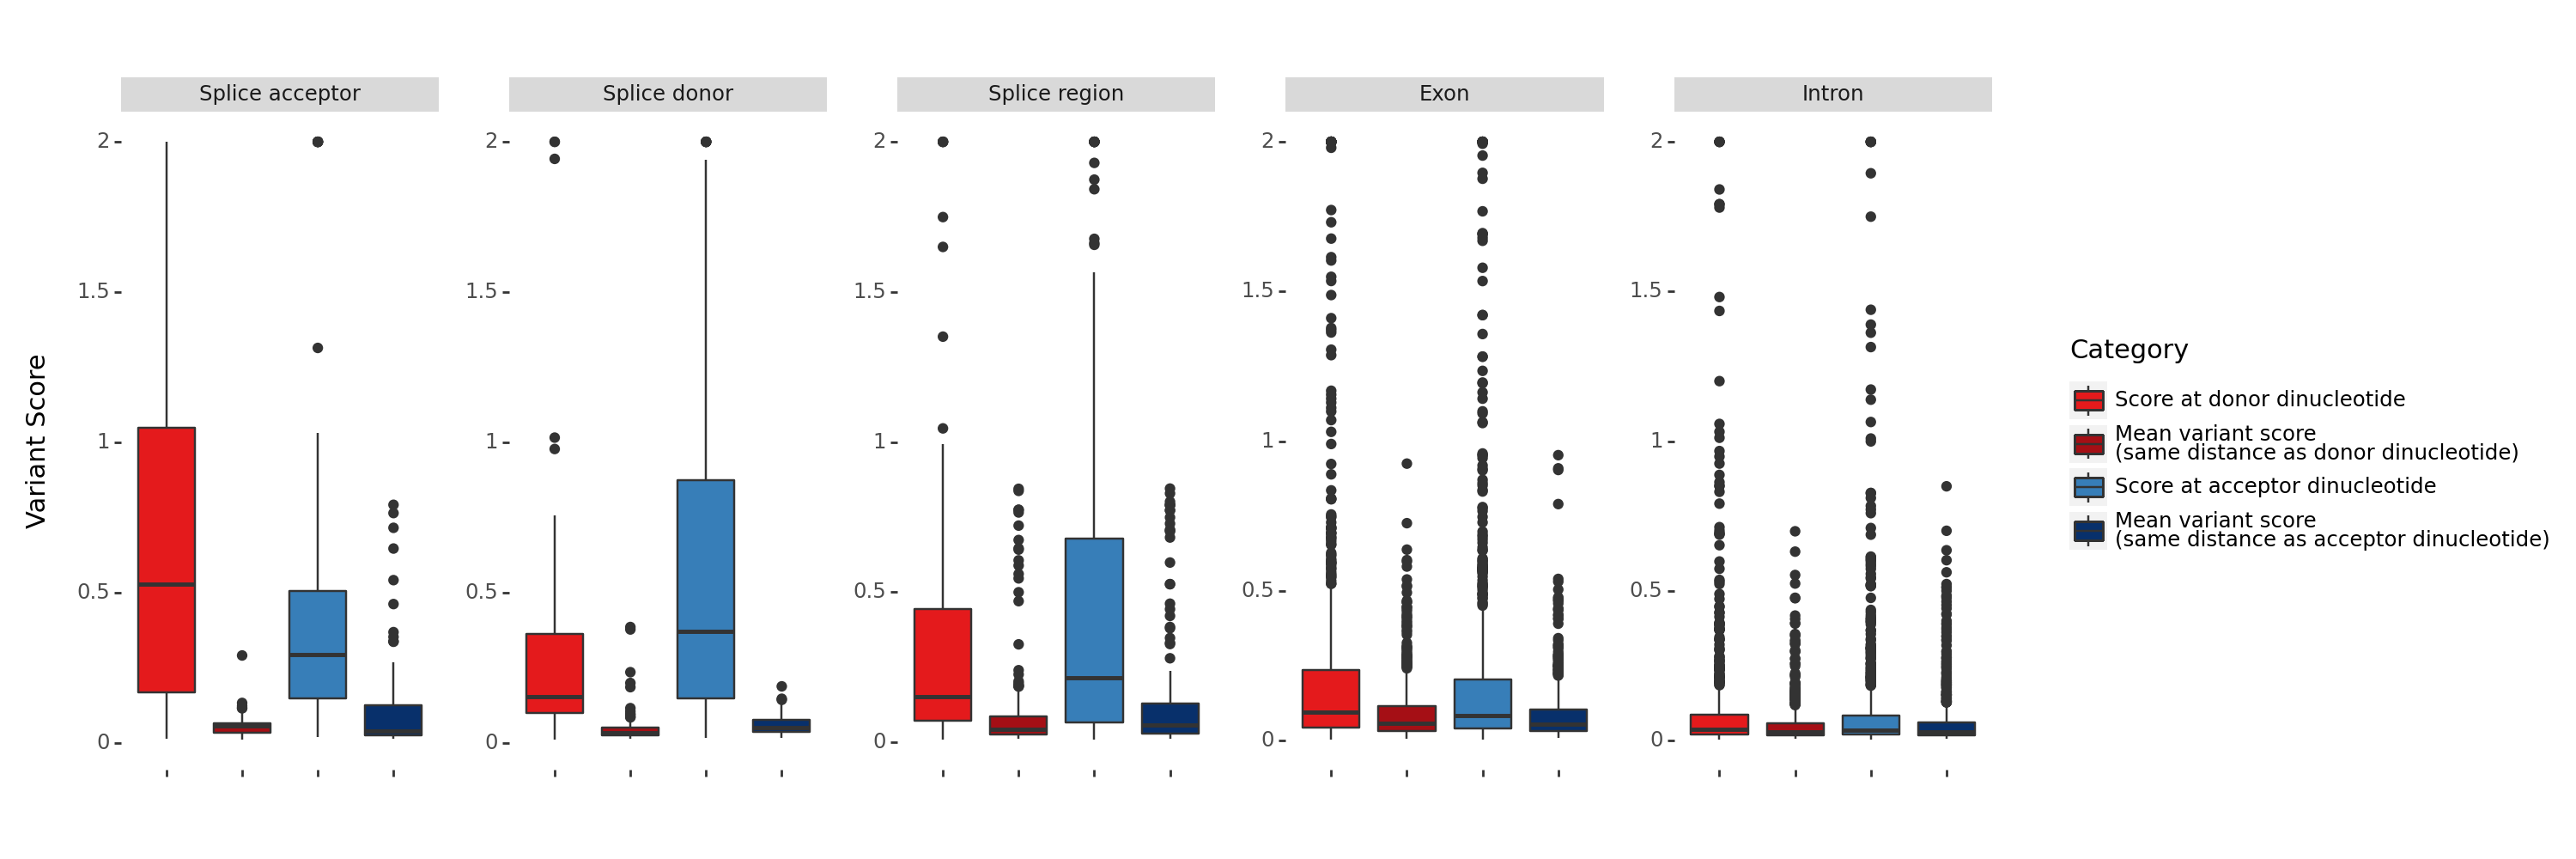

In [134]:
plot_score_background(_df_outlier, score_columns_dict={
    'Score at donor dinucleotide': 'variant_impact_donor_dinu',
    # 'Score at donor': 'variant_impact_donor',
    # # 'Score at acceptor': 'variant_impact_acceptor',
    # # 'Mean variant score': 'mean_variant_impact',
    # 'Mean variant score zero diag': 'mean_variant_impact_zero_diag',
    # 'background_var_donor_10bp_median': 'background_var_donor_10bp_median',
    'Mean variant score \n(same distance as donor dinucleotide)': 'mean_variant_impact_same_dist_donor_dinucleotide',

    'Score at acceptor dinucleotide': 'variant_impact_acceptor_dinu',
    # 'Score at acceptor': 'variant_impact_acceptor',
    # # 'Score at acceptor': 'variant_impact_acceptor',
    # # 'Mean variant score': 'mean_variant_impact',
    # 'Mean variant score zero diag': 'mean_variant_impact_zero_diag',
    # 'background_var_acceptor_10bp_median': 'background_var_acceptor_10bp_median',
    'Mean variant score \n(same distance as acceptor dinucleotide)': 'mean_variant_impact_same_dist_acceptor_dinucleotide',
}, colormap=colormap, category_display_order=category_display_order)

## significance test

In [140]:
import pandas as pd
from scipy.stats import wilcoxon

def compare_paired_score_columns(df, score_column1, score_column2, category_column, alternative='two-sided'):
    """
    Perform the Wilcoxon signed-rank test for two paired score columns across different categories.
    
    Args:
    df (DataFrame): The DataFrame containing the data.
    score_column1 (str): The first score column name.
    score_column2 (str): The second score column name.
    category_column (str): The column name of the categories.
    
    Returns:
    DataFrame: A DataFrame with the p-values and statistic values for each category.
    """
    categories = df[category_column].unique()
    results = []

    for category in categories:
        # Filter the data for the category
        category_data = df[df[category_column] == category]

        # Ensure both score columns have no missing values
        paired_data = category_data.dropna(subset=[score_column1, score_column2])

        data1 = paired_data[score_column1]
        data2 = paired_data[score_column2]
        
        # Perform Wilcoxon signed-rank test
        if len(data1) > 0 and len(data2) > 0:  # Ensure there is enough data to compare
            stat, p_value = wilcoxon(data1, data2, alternative=alternative)
            results.append({
                'Category': category,
                'Statistic': stat,
                'P Value': p_value
            })
        else:
            results.append({
                'Category': category,
                'Statistic': None,
                'P Value': None
            })

    # Return results as a DataFrame
    return pd.DataFrame(results)

In [142]:
splice_site = 'donor'

score_col = f'variant_impact_{splice_site}_dinu'
background_col = f'mean_variant_impact_same_dist_{splice_site}_dinucleotide'
results_df = compare_paired_score_columns(_df_outlier, score_col, background_col, 'VEP_consequence', alternative='greater')
results_df['significant'] = results_df['P Value'] < 0.05

results_df[
    results_df['Category'].isin(['Splice acceptor', 'Splice donor', 'Splice region', 'Exon', 'Intron'])
]

,Category,Statistic,P Value,significant
0,Exon,208872.0,3.047857e-37,True
1,Intron,215103.0,1.072190e-13,True
2,Splice region,9521.0,1.467325e-15,True
3,Splice acceptor,1030.0,2.842171e-13,True
4,Splice donor,2413.0,2.846917e-13,True


In [145]:
splice_site = 'acceptor'

score_col = f'variant_impact_{splice_site}_dinu'
background_col = f'mean_variant_impact_same_dist_{splice_site}_dinucleotide'
results_df = compare_paired_score_columns(_df_outlier, score_col, background_col, 'VEP_consequence', alternative='greater')
# results_df = compare_paired_score_columns(_df_outlier, score_col, background_col, 'VEP_consequence')
results_df['significant'] = results_df['P Value'] < 0.05

results_df[
    results_df['Category'].isin(['Splice acceptor', 'Splice donor', 'Splice region', 'Exon', 'Intron'])
]

,Category,Statistic,P Value,significant
0,Exon,201718.0,1.075331e-30,True
1,Intron,212713.0,1.441580e-12,True
2,Splice region,9859.0,6.301559e-18,True
3,Splice acceptor,1009.0,3.038281e-11,True
4,Splice donor,2413.0,2.846917e-13,True
